### This file contains examples from Part 2 of the QuantEcon Julia Tutorial

Simulating Markov Chains with QuantEcon package.  

In [1]:
using QuantEcon
P=[0.4 0.6; 0.2 0.8] # transition matrix
mc=MarkovChain(P)
x=simulate(mc,100000)
mean(x.==1)

0.25006

Exercise 1: Simple Application of the Kalman filter.  
* all variables scalar  
* hidden state $\{x_t\}$ is a constant
* Dynamics: $A=1, Q=0, x_0=\theta$, where $\theta$ is the true value of the hidden state
* measurement equation: $y_t=\theta + \nu_t$ where $\nu_t$ is $N(0,1)$ and iid
* Simulate the model and plot first five predictive densities $p_t(x)=N(\hat{x}_t,\Sigma_t)$
* $\theta=10, \hat{x}_0=8, \Sigma_0=1$

In [2]:
A=1.0
Q=0.0
G=1.0
R=1.0
theta=10
xhat=8.0
sigma0=1.0
x0=theta
# initialize the Kalman filter
kalman=Kalman(A,G,Q,R)
# set the initial state
set_state!(kalman,xhat,sigma0)

Void


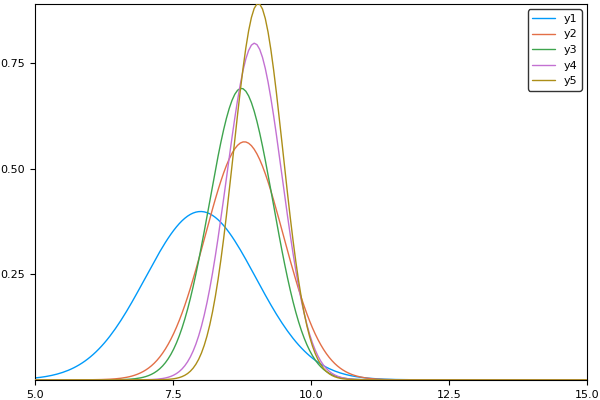

In [3]:
using Distributions
using Plots
# Run update of kalman filter for five runs
N=5
# define grid for x (built around the true value x0=theta)
densities=[]
labels=[]
xgrid=linspace(theta-5,theta+5,200)

for i=1:N
   mean, var=kalman.cur_x_hat, kalman.cur_sigma # this is the current mean and variance
    # plot this
    push!(densities, pdf(Normal(mean, sqrt(var)), xgrid))


    # Generate the noisy signal
    y = theta + randn()

    # Update the Kalman filter
    update!(kalman, y)
end

plot(xgrid, densities, grid=false)


## Single-Agent Models

Exercise 1: Working on the McCall Model 

In [4]:
using Distributions
# define utility function and distributions
function utility(c,sigma)
    if c>0
        out=(c^(1-sigma)-1)/(1-sigma)
    else
        out=-10e6 
    end
    return out
end
    
const n=60 # size of wage vector
const default_w_vec=linspace(10,20,n)
const a, b = 600, 400                          # shape parameters
const dist = BetaBinomial(n-1, a, b)
const default_p_vec = pdf(dist)

60-element Array{Float64,1}:
 3.67931e-23
 2.84383e-21
 1.08458e-19
 2.72048e-18
 5.04754e-17
 7.38675e-16
 8.87878e-15
 9.01291e-14
 7.8848e-13 
 6.03684e-12
 4.09402e-11
 2.48316e-10
 1.35769e-9 
 ⋮          
 0.000352228
 0.000124972
 3.96609e-5 
 1.11503e-5 
 2.74386e-6 
 5.81976e-7 
 1.04261e-7 
 1.53435e-8 
 1.78128e-9 
 1.52988e-10
 8.64331e-12
 2.40987e-13

In [5]:
# create a type called McCall Model (so we can use it multiple times)
type McCall
    alpha::Float64        # Job separation rate
    beta::Float64         # Discount rate
    gammaparam::Float64        # Job offer rate
    c::Float64            # Unemployment compensation
    sigma::Float64        # Utility parameter
    w_vec::Vector{Float64} # Possible wage values
    p_vec::Vector{Float64} # Probabilities over w_vec
    
    # define a function that returns a new instance of this type
    function McCall(alpha=0.2,beta=0.98,gammaparam=0.7,c=6.0,sigma=2.0, w_vec=default_w_vec, p_vec=default_p_vec)
        return new(alpha, beta, gammaparam, c, sigma, w_vec, p_vec) # this new function creates a new instance of the type
    end
end

In [ ]:
# write a function to update the bellman equation 
# we write update_V! (with an exclamation mark because the value of V_new in the argument is going to be modified in place)

In [6]:
function update_bellman!(mcm,V,V_new,U) # V_new is modified, and mcm is an instance of the mccall model
    # Simplify notation
    alpha, beta, sigma, c, gammaparam = mcm.alpha, mcm.beta, mcm.sigma, mcm.c, mcm.gammaparam
    for (ind_w,w) in enumerate(mcm.w_vec)
        V_new[ind_w]=utility(w,sigma)+beta*((1-alpha)*V[ind_w]+alpha*U)      
    end
    U_new = utility(c, sigma) + beta * (1 - gammaparam) * U +
                    beta * gammaparam * sum(max(U, V) .* mcm.p_vec)

    return U_new
end

update_bellman! (generic function with 1 method)

In [7]:
# write a function for solving the model
function solve_mccall(mcm::McCall;tol::Float64=1e-5,maxiter::Int=100 )
    V=ones(length(mcm.w_vec))
    V_new=similar(V) # similar creates an array just like V
    err=tol+1 
    U=1.0
    i=0
    while i<maxiter
        U_new = update_bellman!(mcm, V, V_new, U)
        error_1 = maximum(abs(V_new - V))
        error_2 = abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1
    end

    return V, U
end

solve_mccall (generic function with 1 method)

In [8]:
# solve an instance of the McCall model
mcm=McCall()
V,U=solve_mccall(mcm)


([39.6361,39.6438,39.6513,39.6585,39.6655,39.6723,39.6788,39.6852,39.6914,39.6974  …  39.8485,39.8508,39.853,39.8552,39.8573,39.8595,39.8616,39.8636,39.8656,39.8676],39.693865261373396)


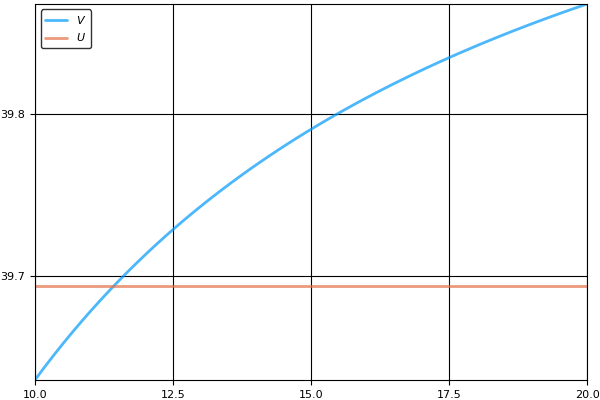

In [9]:
using LaTeXStrings
using Plots
U_vec = U .* ones(length(mcm.w_vec))

plot(mcm.w_vec, 
        [V U_vec],
        lw=2, 
        alpha=0.7, 
        label=[L"$V$" L"$U$"])


### Exercise 2: Stochastic Growth Model

Use Value Function Iteration to compute the solution to a stochastic growth model with piecewise linear interpolation.

In [1]:
# import packages
using QuantEcon
using Optim

#= Arguments
w: array with values of guess for value function
grid: array with values for y
u: function for calculating utility
f: function for calculating production
shocks: array with production shocks 
beta: discount factor scalar
Tw: array with values for update of value function
compute_policy: boolean, optional
=# 

function bellman_operator(w::Array{Float64}, grid::Array{Float64},beta::Float64,shocks::Array{Float64}; compute_policy="False")
    # QuantEcon's LinInterp(x,y) takes the grid points x and the function points at x, y
    w_func=LinInterp(grid,w)
    # w_func is now a function that takes a value in between gridpoints and 
    # gives the interpolated value
    
    # Tw has the same shape as w
    Tw=similar(w)
    c_star=similar(w)
    
    # set Tw[i]=max_c {u(c)+ beta E w(f(y-c)z)}
    # y is the state
    for (i,y) in enumerate(grid)
        # define anonymous function to do maximization
        objective(c)=(-1.0)*(u(c)+beta*mean(w_func.(f(y-c).*shocks)))
        
        opt_choice=optimize(objective, 1e-10,y)
        Tw[i]=-opt_choice.minimum
        c_star[i]=opt_choice.minimizer
    end
    
    if compute_policy==false
        return Tw
    else 
        return Tw,c_star
    end
end

bellman_operator (generic function with 1 method)

In [2]:
# this illustrates how the mean() function works
shocks=exp(0.1*randn(250))
z=mean(shocks) # uses Monte-Carlo integration

1.0019226618160966

In [3]:
# set-up the utility and production function
alpha=0.4
beta=0.96
mu=0
s=0.1

u(c)=log(c)
f(k)=k^alpha

grid_max=4
grid_size=200
shock_size=250

grid_y=collect(linspace(1e-5,grid_max,grid_size))
shocks=exp(mu+s*randn(shock_size))


err=1
function compute_fixedpt(err,maxit)
    
    # iterating on the Bellman Operator
    v_old=5*log(grid_y) # initial guess
    n=35 # of iterations
    tol=1e-3
    while err>tol
        v_new=bellman_operator(v_old,grid_y,beta,shocks;compute_policy=false)
        err=maximum(abs(v_old-v_new))
        println(err)
        v_old=v_new
    end
    return v_old
end


compute_fixedpt (generic function with 1 method)

In [4]:
# now use the QuantEcon.compute_fixed_point method to calculate the value function
vstar=compute_fixedpt(1,100)

6.322965868688232
6.058430754112138
3.8392144887406374
1.9776252383312212
0.9363480566126037
0.8471915593055077
0.7933755463445777
0.7539753011414039
0.7208709490041407
0.6909040150339951
0.6628330754520917
0.6361527903942541
0.6106426225821693
0.5861923414432741
0.5627352150440412
0.5402221846664101
0.5186119063892622
0.4978668959278387
0.4779520149079044
0.458833855502073
0.44048047101167676
0.4228612405445453
0.4059467864570685
0.389708913283469
0.37412055609332384
0.3591557335965305
0.3447895041554645
0.3309979239519265
0.31775800697951695
0.3050476866948273
0.29284577922497235
0.2811319480551333
0.26988667013277023
0.2590912033272019
0.24872755519423606
0.23877845298629197
0.22922731486698922
0.22005822227215788
0.21125589338148387
0.2028056576461914
0.19469343134035455
0.18690569408667557
0.17942946632326695
0.17225228767019019
0.16536219616357428
0.15874770831689133
0.15239779998434244
0.14630188798497912
0.1404498124655973
0.13483181996688742
0.12943854716838743
0.1242610052814

200-element Array{Float64,1}:
 -57.0042
 -32.7133
 -31.5872
 -30.9286
 -30.4615
 -30.0991
 -29.8031
 -29.5527
 -29.3359
 -29.1446
 -28.9735
 -28.8188
 -28.6775
   ⋮     
 -24.2103
 -24.2016
 -24.1931
 -24.1845
 -24.1761
 -24.1676
 -24.1592
 -24.1509
 -24.1426
 -24.1343
 -24.1261
 -24.1179

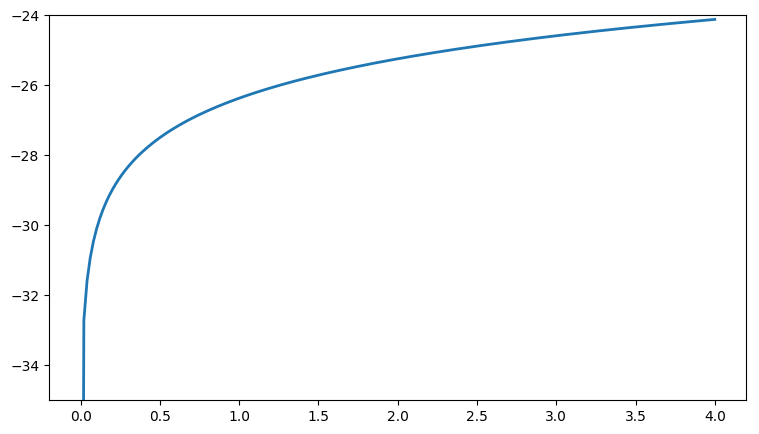

In [5]:
using PyPlot
# plot the results
fig,ax=subplots(figsize=(9,5)) # define the subplot size
ax[:set_ylim](-35,-24)
ax[:plot](grid_y,vstar,lw=2)
show()


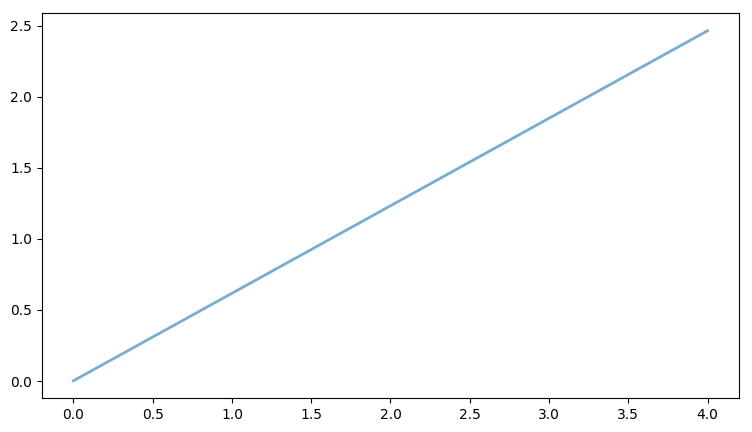

In [6]:
# compute the policy function 
v_star,c_star=bellman_operator(vstar,grid_y,beta,shocks;compute_policy=true)
fig,ax=subplots(figsize=(9,5))
ax[:plot](grid_y,c_star,lw=2,alpha=0.6)
show()

#### Exercise: Once an optimal consumption policy is given, we can plot the dynamics for the capital stock from simulations

In [18]:
# initial condition is y0=0.1
# do it for a sequence of three discount factors (0.9,0.94,0.98)

function simulate_capital(yo,grid_y::Array{Float64},beta::Float64,shocks)
    # now use the QuantEcon.compute_fixed_point method to calculate the value function
    v_old=5*log(grid_y)
    vstar=compute_fixedpt(1,100)
    vstar,cstar=bellman_operator(vstar,grid_y,beta,shocks;compute_policy=true)
    cfunc=LinInterp(grid_y,cstar)
    T=100
    ypath=zeros(T,1)
    kpath=similar(ypath)
    ypath[1]=yo
    shocks=exp(0.1*randn(T))
    for i=2:T
        c=cfunc(ypath[i-1])
        kpath[i]=ypath[i-1]-c
        ypath[i]=(kpath[i]^alpha)*shocks[i]
    end
    
    return ypath
    
end


simulate_capital (generic function with 2 methods)

simulate_capital(Any, Array{Float64, N<:Any}, Float64, Any) in module Main at In[12]:6 overwritten at In[18]:6.


In [19]:
beta1=0.9
beta2=0.94
beta3=0.98
shocks=exp(mu+s*randn(100))
ypath1=simulate_capital(0.1,grid_y,0.9,shocks)
ypath2=simulate_capital(0.1,grid_y,0.94,shocks)
ypath3=simulate_capital(0.1,grid_y,0.98,shocks)

6.304912779597824
6.008974163193535
3.8194675656583996
1.9724948639187119
0.9409391949065249
0.8514383194373805
0.7973860335013443
0.7578010799069537
0.7245336600811036
0.694417616120413
0.666204891254992
0.6393891193722236
0.6137491690764669
0.5891744617685735
0.5655979706630418
0.5429703942485169
0.521250172182361
0.5003996245890434
0.4803834317106155
0.4611680145087238
0.44272126319491534
0.425012400850477
0.40801190027316636
0.3916914225154624
0.37602376494320744
0.36098281408724553
0.3465435014244669
0.3326817613293027
0.3193744908614562
0.30659951122136064
0.2943355307703328
0.2825621095387163
0.2712596251568513
0.2604092401504232
0.24999287054437147
0.2399931557225905
0.2303934294937129
0.22117769231395812
0.21233058462136967
0.20383736123663
0.19568386678705707
0.18785651211569743
0.18034225163105688
0.17312856156570788
0.16620341910309122
0.15955528233902427
0.1531730710454191
0.1470461482036427
0.1411643022754845
0.13551773018448898
0.13009702097707887
0.12489314013800268
0.1

100×1 Array{Float64,2}:
 0.1     
 0.248253
 0.410465
 0.501506
 0.519189
 0.494153
 0.589108
 0.54737 
 0.521658
 0.583966
 0.541757
 0.529617
 0.521211
 ⋮       
 0.57814 
 0.493298
 0.530523
 0.586074
 0.494194
 0.544297
 0.573091
 0.460471
 0.50829 
 0.529457
 0.547564
 0.595415

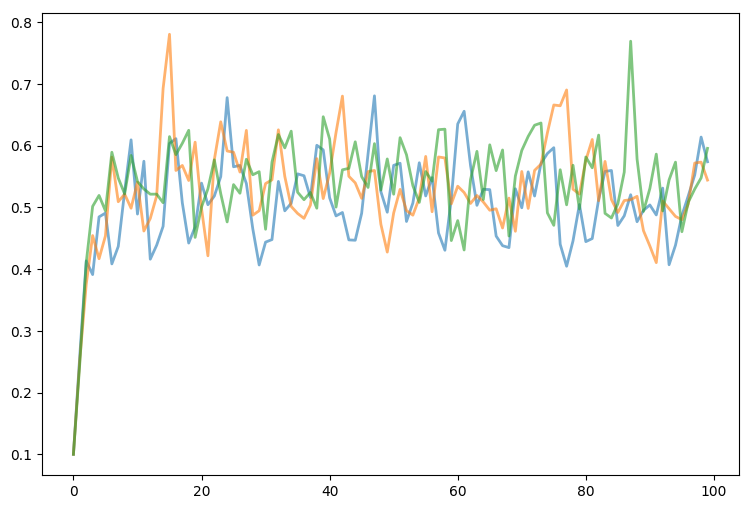

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000246C2C50>

In [21]:
# Plot simulation results
fig, ax = subplots(figsize=(9, 6))
ax[:plot](ypath1, lw=2, alpha=0.6, label="beta = 0.9" )
ax[:plot](ypath2, lw=2, alpha=0.6, label="beta = 0.94" )
ax[:plot](ypath3, lw=2, alpha=0.6, label="beta = 0.98" )


### Exercise 3: Policy Iteration Practice

Solve the income fluctuation problem using policy function iteration.

In [1]:
using Interpolations
using Roots
using Optim
using QuantEcon
# set-up model structure
# utility and marginal utility functions
u(x) = log(x)
du(x) = 1 ./ x
type ConsumerProblem # collect the parameters associated with the IFP
    r::Float64
    R::Float64
    bet::Float64
    b::Float64
    Pi::Matrix{Float64}
    z_vals::Vector{Float64}
    agrid::LinSpace{Float64}
    
end


function ConsumerProblem(;r=0.01, bet=0.96, Pi=[0.6 0.4; 0.05 0.95],
                         z_vals=[0.5, 1.0], b=0.0, grid_max=16, grid_size=50)
    R = 1 + r
    agrid = linspace(-b, grid_max, grid_size)

    ConsumerProblem(r, R, bet, b, Pi, z_vals, agrid)
end



ConsumerProblem

In [2]:
function update_polfunction(cp::ConsumerProblem,pol_old::Matrix)
    
    r,R,bet,b,Pi,z_vals,agrid=cp.r,cp.R,cp.bet,cp.b,cp.Pi,cp.z_vals,cp.agrid
    lb_opt=1e-6 # lower bound for asset holding
    pol_new=similar(pol_old) # updated policy function
    c_pol=similar(pol_old)
    for (i_z,z) in enumerate(z_vals)
        for (i_a,a) in enumerate(agrid)
            
            if (du(R*a+z-agrid[1])-bet*R*dot(Pi[i_z,:],du(R*agrid[1]+z_vals-pol_old[1,:])))>0
                pol_new[i_a,i_z]=b
                continue
            else
                
                # borrowing constraint doesn't bind
                function opt_a(aprime)
                    pol_interp=similar(z_vals)
                    for (i_zp,zp) in enumerate(z_vals)
                        itp=interpolate((agrid,),vec(pol_old[:,i_zp]),Gridded(Linear()))
                        extp=extrapolate(itp,Flat())
                        pol_interp[i_zp]=extp[aprime]
                    end
                    c=R*a+z-aprime
                    if c<=0.0 
                        c=1e-7
                    end
                    cprime=R*aprime+z_vals-pol_interp
                    cprime[cprime.<0.0]=1e-6 
                    LHS=du(c)
                    RHS=bet*R*dot(Pi[i_z,:],du(cprime))
                    f=RHS-LHS
                    return f
                end
                res = fzero(opt_a,0.0)
                pol_new[i_a,i_z]=res
                c_pol[i_a,i_z]=R*a+z-pol_new[i_a,i_z]
                
            end
        end
        
    end
    return pol_new,c_pol
end

update_polfunction (generic function with 1 method)

In [3]:
function solve_politer(cp::ConsumerProblem)
    r,R,bet,b,Pi,z_vals,agrid=cp.r,cp.R,cp.bet,cp.b,cp.Pi,cp.z_vals,cp.agrid
    err=1.0
    tol=1e-4
    pol_old=ones(length(agrid),length(z_vals))
    for (ia,a) in enumerate(agrid)
        pol_old[ia,:]=agrid[ia]
    end
    pol_new=similar(pol_old)
    c_pol=similar(pol_old)
    while err>tol 
        pol_new,c_pol=update_polfunction(cp::ConsumerProblem,pol_old::Matrix)
        err=maximum(abs(pol_new-pol_old))
        #println(err)
        pol_old=pol_new
    end
    return pol_new,c_pol
end

solve_politer (generic function with 1 method)

In [4]:
cp=ConsumerProblem()
aprime,c_pol=solve_politer(cp)

(
[0.0 0.0417279; 0.117071 0.295515; … ; 14.1334 14.5679; 14.4437 14.8786],

[0.0 0.958272; 0.712724 1.03428; … ; 2.19683 2.26231; 2.21626 2.28137])

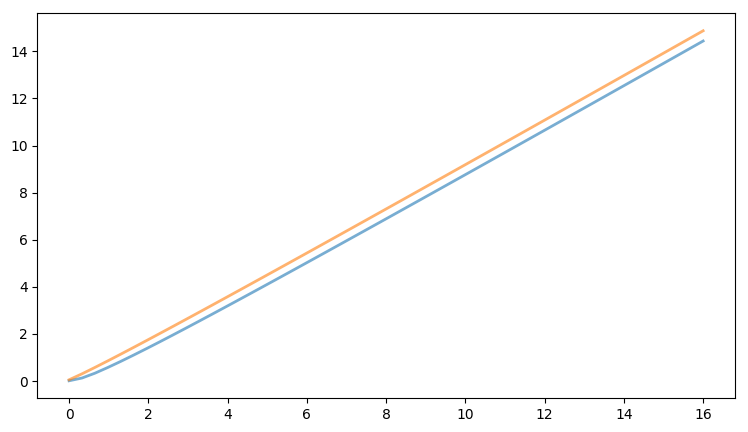

In [7]:
using PyPlot
fig,ax=subplots(figsize=(9,5))
ax[:plot](cp.agrid,aprime,lw=2,alpha=0.6)
show()

Exercise: Show the consumption policy function for different interest rates.

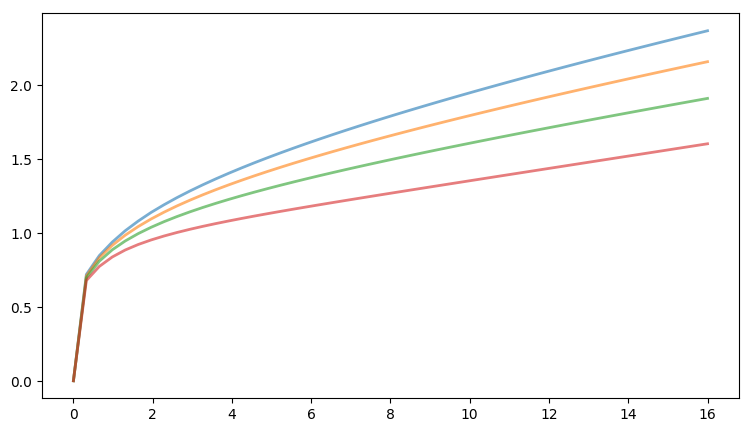

In [10]:
rgrid=linspace(0.0,0.04,4)
aprimemat=zeros(50,2,4)
cmat=similar(aprimemat)
fig,ax=subplots(figsize=(9,5))
for i in 1:4
    rval=rgrid[i]
    cp=ConsumerProblem(r=rval)
    aprimemat[:,:,i],cmat[:,:,i]=solve_politer(cp)
    
    ax[:plot](cp.agrid,cmat[:,1,i],lw=2,alpha=0.6)

    
end
show()


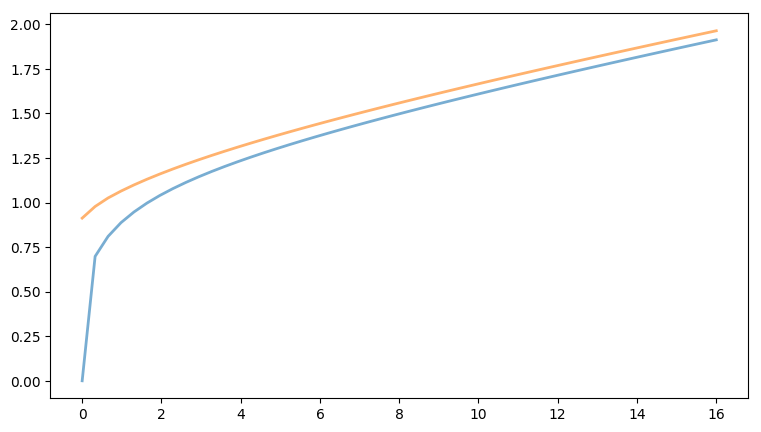

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000001F135C50>
 PyObject <matplotlib.lines.Line2D object at 0x000000001F135E48>

In [9]:
c_mat=zeros(50,2,4)
fig,ax=subplots(figsize=(9,5))

    
ax[:plot](cp.agrid,cmat[:,:,3],lw=2,alpha=0.6)
